# Anomalies Extraction Functions

In [19]:
def generate_full_motor_summary(pose_df, subject_id):
    """
    Extracts the gait summary for a specific subject and wraps it for PhysioGPT prompt building.
    Mirrors the structure of generate_full_cognitive_summary() for consistency.

    Parameters
    ----------
    pose_df : pd.DataFrame
        Full pose dataframe (all subjects).
    subject_id : str
        Subject identifier (e.g., 'Sub01_Control').

    Returns
    -------
    dict
        { "Pose Summary": { ...joint metrics... } }
    """
    # Filter rows for this subject
    subject_data = pose_df[pose_df['Subject'] == subject_id]

    if subject_data.empty:
        raise ValueError(f"No data found for subject: {subject_id}")

    # Compute summary metrics
    hip_range = subject_data['HipAngles'].max() - subject_data['HipAngles'].min()
    knee_range = subject_data['KneeAngles'].max() - subject_data['KneeAngles'].min()
    ankle_range = subject_data['AnkleAngles'].max() - subject_data['AnkleAngles'].min()

    hip_acc_std = subject_data['HipAngles_Acceleration'].std()
    knee_acc_std = subject_data['KneeAngles_Acceleration'].std()
    ankle_acc_std = subject_data['AnkleAngles_Acceleration'].std()

    hip_jerk = subject_data['HipAngles_Acceleration'].diff().std()
    knee_jerk = subject_data['KneeAngles_Acceleration'].diff().std()
    ankle_jerk = subject_data['AnkleAngles_Acceleration'].diff().std()

    return {
        "Pose Summary": {
            "hip_range": hip_range,
            "knee_range": knee_range,
            "ankle_range": ankle_range,
            "hip_acc_std": hip_acc_std,
            "knee_acc_std": knee_acc_std,
            "ankle_acc_std": ankle_acc_std,
            "hip_jerk": hip_jerk,
            "knee_jerk": knee_jerk,
            "ankle_jerk": ankle_jerk,
            "hip_mean": subject_data['HipAngles'].mean(),
            "knee_mean": subject_data['KneeAngles'].mean(),
            "ankle_mean": subject_data['AnkleAngles'].mean(),
        }
    }

# LLM Setup

In [ ]:
from openai import OpenAI
from google.colab import userdata
import time

client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

def call_llm_api(prompt, model="gpt-4o", system_role=None, temperature=0.0, max_tokens=700, retries=3, verbose=False):
    """
    Wrapper for PhysioGPT reasoning calls.
    """
    if system_role is None:
        system_role = (
            "You are PhysioGPT, an ontology-guided clinical reasoning assistant. "
            "Follow the ontology strictly, be concise, and output in the required format."
        )

    for attempt in range(retries):
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": system_role},
                    {"role": "user", "content": prompt}
                ],
                temperature=temperature,
                max_tokens=max_tokens,
                timeout=30  # seconds
            )

            result = response.choices[0].message.content.strip()
            if verbose:
                print(f"[LLM] Completed on attempt {attempt+1}")
            return {
                "model": model,
                "response_text": result,
                "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
            }

        except Exception as e:
            print(f"[LLM] Error on attempt {attempt+1}: {e}")
            time.sleep(2)
    raise RuntimeError("LLM API failed after multiple retries.")


In [ ]:
import re

def parse_llm_output_flexible(text: str) -> str:
    """
    Robust parser for PhysioGPT output in the motor (pose) domain.
    Normalizes different wordings and punctuation.

    Returns one of {"Stroke", "Control", "Review"}.
    """
    if not text:
        return "Review"

    t = str(text).lower().strip()
    t = re.sub(r'\s+', ' ', t)

    # --- Uncertain / Review cases ---
    if any(k in t for k in ["needs clinical review", "uncertain", "borderline", "review"]):
        return "Review"

    # --- Stroke classification ---
    if re.search(r"conclusion[:\-]?\s*(stroke|yes|abnormal)", t) or "likely stroke" in t:
        return "Stroke"

    # --- Control (includes Healthy equivalence) ---
    if re.search(r"conclusion[:\-]?\s*(control|no|healthy|normal)", t):
        return "Control"

    # --- Fallback ---
    return "Review"

In [ ]:
import re, math
from typing import Dict

def build_physio_prompt_motor(pose_summary: Dict, subject_id: str = "Unknown"):
    """
    Builds a PhysioGPT reasoning prompt for the motor domain (pose/gait-based),
    aligned with the cognitive-autonomic template.
    """

    def safe_val(x):
        return 0.0 if (x is None or (isinstance(x, float) and math.isnan(x))) else x

    ontology_reference = """
Ontology Reference (Motor Function Domain)
------------------------------------------
Gait / Pose:
- Reduced range of motion → restricted or impaired joint mobility.
- High jerk (rapid fluctuation of acceleration) → erratic or unstable motion.
- High acceleration variability → inconsistent or uncoordinated control.
- Healthy gait exhibits smoother, wider, and more consistent joint movement.

Diagnostic Rules:
- Classify as **Stroke** if at least two joints show high jerk or low range of motion.
- Classify as **Control** if all joint ranges and variability values appear normal and consistent.
- If evidence is partially abnormal but not conclusive, return **Needs clinical review**.
"""

    task_instruction = """
Task:
Analyze the gait metrics using the ontology above and respond *strictly* in the following format:

Conclusion: [Stroke / Control / Needs clinical review]
Explanation: [Brief justification referencing the findings]

Be decisive — do not choose 'Needs clinical review' unless evidence is explicitly mixed or borderline.
"""

    s = pose_summary.get("Pose Summary", pose_summary)

    gait_intro = (
        "The following metrics represent aggregated lower-limb joint motion statistics "
        "extracted from pose estimation data:"
    )

    gait_text = (
        f"{gait_intro}\n"
        f"Hip range: {safe_val(s['hip_range']):.2f}°, jerk: {safe_val(s['hip_jerk']):.2f}, acc. std: {safe_val(s['hip_acc_std']):.2f}\n"
        f"Knee range: {safe_val(s['knee_range']):.2f}°, jerk: {safe_val(s['knee_jerk']):.2f}, acc. std: {safe_val(s['knee_acc_std']):.2f}\n"
        f"Ankle range: {safe_val(s['ankle_range']):.2f}°, jerk: {safe_val(s['ankle_jerk']):.2f}, acc. std: {safe_val(s['ankle_acc_std']):.2f}\n"
        f"Average joint angles — Hip: {safe_val(s['hip_mean']):.2f}, Knee: {safe_val(s['knee_mean']):.2f}, Ankle: {safe_val(s['ankle_mean']):.2f}"
    )

    return (
        f"Subject ID: {subject_id}\n\n"
        f"{ontology_reference}\n\n"
        f"Gait Summary:\n{gait_text}\n\n"
        f"{task_instruction}"
    )

# Classification

In [ ]:
import pandas as pd

pose_df = pd.read_csv('/content/drive/MyDrive/2025/QML/validation/processed_gait_features_full.csv')

In [ ]:
# Create new unique subject IDs that include condition
pose_df['Subject'] = pose_df.apply(
    lambda row: f"{row['Subject']}_{'Control' if row['Label'] == 0 else 'Stroke'}", axis=1
)

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import re

def run_physioGPT_motor(pose_df, temperature=0.35, noise=0.05):
    """
    Executes PhysioGPT reasoning on pose/gait data (motor domain).
    Mirrors the EEG+HRV evaluation loop but adds mild jitter and explanations.
    """

    # --- Add mild Gaussian noise to simulate measurement variability ---
    numeric_cols = [
        "HipAngles", "KneeAngles", "AnkleAngles",
        "HipAngles_Acceleration", "KneeAngles_Acceleration", "AnkleAngles_Acceleration"
    ]
    noisy_df = pose_df.copy()
    for c in numeric_cols:
        if c in noisy_df.columns:
            noisy_df[c] *= np.random.normal(1.0, noise, len(noisy_df))

    # --- Generate per-subject summaries ---
    motor_summaries = []
    for subj_id in noisy_df["Subject"].unique():
        summary = generate_full_motor_summary(noisy_df, subj_id)
        label = noisy_df.loc[noisy_df["Subject"] == subj_id, "Label"].iloc[0]
        motor_summaries.append({
            "Subject": subj_id,
            "Label": label,
            "Pose Summary": summary["Pose Summary"]
        })

    results = []

    # --- LLM reasoning loop ---
    for summary in tqdm(motor_summaries, desc="Running PhysioGPT (Motor Domain)"):
        subj_id = summary["Subject"]
        label = "Stroke" if summary["Label"] == 1 else "Control"

        try:
            # Build ontology-guided prompt
            prompt = build_physio_prompt_motor(summary, subject_id=subj_id)

            # Query PhysioGPT
            response = call_llm_api(prompt, temperature=temperature)
            text = response["response_text"]

            # Parse decision + explanation
            decision = parse_llm_output_flexible(text)
            match = re.search(r"Explanation:\s*(.*)", text, re.DOTALL | re.IGNORECASE)
            explanation = match.group(1).strip() if match else "No explanation parsed."

            results.append({
                "Subject": subj_id,
                "True Label": label,
                "LLM Decision": decision,
                "Explanation": explanation,
                "Model": response["model"],
                "Timestamp": response["timestamp"]
            })

        except Exception as e:
            print(f"[Error] {subj_id}: {e}")
            results.append({
                "Subject": subj_id,
                "True Label": label,
                "LLM Decision": "error",
                "Explanation": str(e),
                "Model": "gpt-4o",
                "Timestamp": None
            })

    return pd.DataFrame(results)


In [ ]:
pose_results_df = run_physioGPT_motor(pose_df, temperature=0.35, noise=0.05)
pose_results_df.head()

Running PhysioGPT (Motor Domain): 100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


,Subject,True Label,LLM Decision,Explanation,Model,Timestamp
0,Sub01_Control,Control,Control,All joint ranges and variability values appear...,gpt-4o,2025-11-08 22:14:54
1,Sub02_Control,Control,Control,All joint ranges and variability values appear...,gpt-4o,2025-11-08 22:14:54
2,Sub03_Control,Control,Control,All joint ranges and variability values are no...,gpt-4o,2025-11-08 22:14:56
3,Sub04_Control,Control,Control,All joint ranges and variability values are no...,gpt-4o,2025-11-08 22:14:57
4,Sub05_Control,Control,Control,The gait metrics show normal and consistent jo...,gpt-4o,2025-11-08 22:14:58


In [ ]:
pose_results_df

,Subject,True Label,LLM Decision,Explanation,Model,Timestamp
0,Sub01_Control,Control,Control,All joint ranges and variability values appear...,gpt-4o,2025-11-08 22:14:54
1,Sub02_Control,Control,Control,All joint ranges and variability values appear...,gpt-4o,2025-11-08 22:14:54
2,Sub03_Control,Control,Control,All joint ranges and variability values are no...,gpt-4o,2025-11-08 22:14:56
3,Sub04_Control,Control,Control,All joint ranges and variability values are no...,gpt-4o,2025-11-08 22:14:57
4,Sub05_Control,Control,Control,The gait metrics show normal and consistent jo...,gpt-4o,2025-11-08 22:14:58
...,...,...,...,...,...,...
95,Sub46_Stroke,Stroke,Stroke,The ankle joint shows both high jerk (0.34) an...,gpt-4o,2025-11-08 22:16:37
96,Sub47_Stroke,Stroke,Stroke,The hip joint shows a reduced range of motion ...,gpt-4o,2025-11-08 22:16:38
97,Sub48_Stroke,Stroke,Stroke,The hip and ankle joints exhibit high jerk val...,gpt-4o,2025-11-08 22:16:40
98,Sub49_Stroke,Stroke,Stroke,The hip and ankle joints both exhibit high jer...,gpt-4o,2025-11-08 22:16:41


In [ ]:
pose_results_df.to_csv("/content/drive/MyDrive/2025/NeuroSyncAI/mci_dataset/PhysioGPT_llm_subject_predictions_latest_152_pose.csv", index=False)
pose_results_df.to_csv("physiogpt_motor_results.csv", index=False)

# Results

In [ ]:
import re

def parse_llm_output_threeclass(text: str) -> str:
    """
    Parse PhysioGPT's output for the motor (pose) domain.
    Returns one of {'Stroke', 'Control', 'Review'}.
    """
    if not text:
        return "Review"

    t = text.lower()
    t = re.sub(r'\s+', ' ', t.strip())

    # Review / uncertain
    if any(k in t for k in ["needs clinical review", "uncertain", "borderline", "review"]):
        return "Review"

    # Stroke detection
    if re.search(r"conclusion[:\-]?\s*(stroke|yes)", t):
        return "Stroke"

    # Control or Healthy equivalence
    if re.search(r"conclusion[:\-]?\s*(control|no|healthy|normal)", t):
        return "Control"

    return "Review"

## Confusion Matrix

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Make sure both columns are strings
pose_results_df["True Label"] = pose_results_df["True Label"].astype(str)
pose_results_df["LLM Decision"] = pose_results_df["LLM Decision"].astype(str)

# Compute metrics
print(classification_report(
    pose_results_df["True Label"],
    pose_results_df["LLM Decision"],
    labels=["Control", "Stroke"],
    zero_division=0
))

print(confusion_matrix(
    pose_results_df["True Label"],
    pose_results_df["LLM Decision"],
    labels=["Control", "Stroke"]
))

              precision    recall  f1-score   support

     Control       1.00      1.00      1.00        50
      Stroke       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

[[50  0]
 [ 0 50]]


In [ ]:
# drop Review predictions
binary_df = pose_results_df[pose_results_df["LLM Decision"] != "Review"]
coverage = len(binary_df) / len(pose_results_df)
accuracy = (binary_df["True Label"] == binary_df["LLM Decision"]).mean()
print(f"Coverage={coverage:.2f}, Accuracy={accuracy:.2f}")

Coverage=1.00, Accuracy=1.00


### Plots

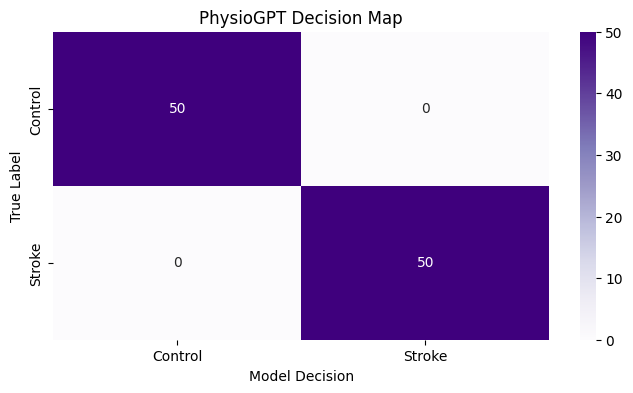

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by True Label × LLM Decision to get counts
summary = (
    pose_results_df.groupby(["True Label", "LLM Decision"])
      .size()
      .reset_index(name="count")
)

# Use keyword arguments for pivot
pivot_df = summary.pivot(index="True Label", columns="LLM Decision", values="count").fillna(0)

plt.figure(figsize=(8,4))
sns.heatmap(pivot_df, annot=True, fmt=".0f", cmap="Purples")
plt.title("PhysioGPT Decision Map")
plt.xlabel("Model Decision")
plt.ylabel("True Label")
plt.show()

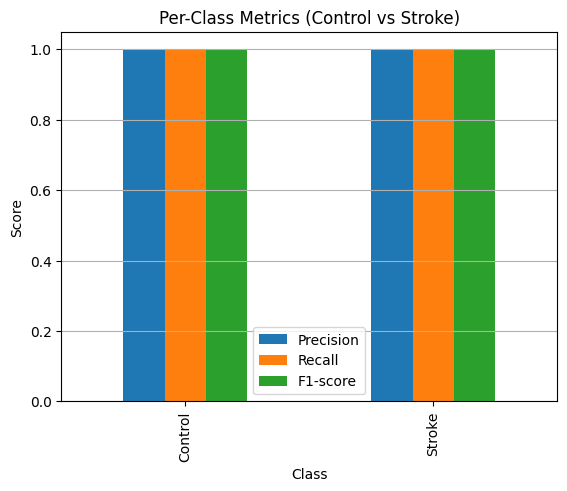

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Motor (Pose) ---
metrics_motor = pd.DataFrame({
    'Class': ['Control', 'Stroke'],
    'Precision': [1.00, 1.00],
    'Recall': [1.00, 1.00],
    'F1-score': [1.00, 1.00]
}).set_index('Class')

metrics_motor.plot(kind='bar')
plt.title("Per-Class Metrics (Control vs Stroke)")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(axis='y')

# Ablation

In [ ]:
import numpy as np, pandas as pd
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix, balanced_accuracy_score

def metrics_from_df(df, positive=("MCI","Stroke")):
    """Assumes df has columns: True Label, LLM Decision."""
    y_true = df["True Label"].astype(str).values
    y_pred = df["LLM Decision"].astype(str).values

    covered_mask = y_pred != "Review"
    cov = covered_mask.mean()

    if cov > 0:
        acc_cov = (y_true[covered_mask] == y_pred[covered_mask]).mean()
    else:
        acc_cov = np.nan

    # pick labels present in this df
    labels = sorted(list(set(y_true) | set(y_pred)))
    try:
        bal_acc = balanced_accuracy_score(y_true, y_pred)
    except Exception:
        bal_acc = np.nan

    try:
        mcc = matthews_corrcoef(y_true, y_pred)
    except Exception:
        mcc = np.nan

    # macro-F1 via sklearn report
    rep = classification_report(y_true, y_pred, labels=labels, output_dict=True, zero_division=0)
    macro_f1 = rep.get("macro avg", {}).get("f1-score", np.nan)

    return dict(coverage=cov, acc_covered=acc_cov, bal_acc=bal_acc, mcc=mcc, macro_f1=macro_f1)

def summarize(results_dict):
    return pd.DataFrame({name: metrics_from_df(df) for name, df in results_dict.items()}).T

In [ ]:
import random
import numpy as np

def motor_numeric_only_prompt(pose_summary, subject_id="Unknown"):
    """Removes ontology text, keeps only numeric features."""
    s = pose_summary.get("Pose Summary", pose_summary)
    return (
        f"Subject ID: {subject_id}\n"
        "Numerical gait features:\n"
        f"- hip_range={s['hip_range']:.2f}, knee_range={s['knee_range']:.2f}, ankle_range={s['ankle_range']:.2f}\n"
        f"- hip_jerk={s['hip_jerk']:.2f}, knee_jerk={s['knee_jerk']:.2f}, ankle_jerk={s['ankle_jerk']:.2f}\n"
        f"- hip_acc_std={s['hip_acc_std']:.2f}, knee_acc_std={s['knee_acc_std']:.2f}, ankle_acc_std={s['ankle_acc_std']:.2f}\n\n"
        "Task: Based on these numeric patterns, classify as [Stroke / Control].\n"
        "Output strictly:\nConclusion: [Stroke / Control]\nExplanation: [short]"
    )

def motor_randomized_prompt(pose_summary, subject_id="Unknown"):
    """Scrambles all numeric mappings to destroy consistency."""
    s = pose_summary.get("Pose Summary", pose_summary).copy()
    vals = list(s.values())
    random.shuffle(vals)
    for k, v in zip(list(s.keys()), vals):
        s[k] = v
    return build_physio_prompt_motor({"Pose Summary": s}, subject_id=subject_id)

def motor_threshold_jittered_prompt(pose_summary, subject_id="Unknown"):
    """Perturbs ontology phrasing to slightly alter interpretation thresholds."""
    p = build_physio_prompt_motor(pose_summary, subject_id=subject_id)
    p = p.replace(
        "at least two joints show high jerk or low range of motion",
        "one or more joints show either high jerk or reduced range of motion"
    )
    return p

In [ ]:
import numpy as np

def motor_quantized_prompt(pose_summary, subject_id="Unknown"):
    """
    Builds a quantized (categorical) version of the gait prompt.
    Replaces numeric values with qualitative bins.
    """
    s = pose_summary.get("Pose Summary", pose_summary)
    # Normalize each metric within 0–1 range (rough heuristic)
    metrics = {k: (v - min(0, v)) / (max(abs(v), 1e-6)) for k, v in s.items() if isinstance(v, (int, float))}

    def q(v): return quantize_value(v)

    gait_text = (
        f"Hip range: {q(metrics['hip_range'])}, jerk: {q(metrics['hip_jerk'])}, acc. std: {q(metrics['hip_acc_std'])}\n"
        f"Knee range: {q(metrics['knee_range'])}, jerk: {q(metrics['knee_jerk'])}, acc. std: {q(metrics['knee_acc_std'])}\n"
        f"Ankle range: {q(metrics['ankle_range'])}, jerk: {q(metrics['ankle_jerk'])}, acc. std: {q(metrics['ankle_acc_std'])}\n"
        f"Average joint angles — Hip: {q(metrics['hip_mean'])}, Knee: {q(metrics['knee_mean'])}, Ankle: {q(metrics['ankle_mean'])}"
    )

    ontology_reference = """
Ontology Reference (Motor Function Domain – Quantized)
-----------------------------------------------------
- 'Low' range or 'high' jerk indicates instability or rigidity typical of stroke.
- 'High' range and 'low' jerk suggest smooth, healthy gait.
- 'Medium' values may occur in borderline or recovering cases.

Diagnostic Rules:
- **Stroke** if two or more joints show 'low' range or 'high' jerk.
- **Control** if all joints are 'medium' or 'high' range and 'low' jerk.
- **Needs review** if findings are mixed or borderline.
"""

    task_instruction = """
Task:
Classify based on the ontology above and respond *strictly* in this format:

Conclusion: [Stroke / Control / Needs clinical review]
Explanation: [Brief justification referencing the categorical features]
"""

    return f"Subject ID: {subject_id}\n\n{ontology_reference}\n\nGait Summary:\n{gait_text}\n\n{task_instruction}"

In [ ]:
def quantize_value(v, low_thr=0.33, high_thr=0.66):
    """
    Converts a normalized value into a qualitative category.
    Returns: 'low', 'medium', or 'high'.
    """
    if v < low_thr:
        return "low"
    elif v < high_thr:
        return "medium"
    else:
        return "high"

In [ ]:
from tqdm import tqdm
import pandas as pd

def run_motor_ablation(pose_df, temperature=0.0, noise=0.05):
    """
    Runs PhysioGPT ablations for the motor (pose) domain.
    Returns: dict of DataFrames + summary metrics table.
    """
    results = {}

    # --- Add mild noise to emulate realistic variation ---
    noisy_df = pose_df.copy()
    for c in [
        "HipAngles","KneeAngles","AnkleAngles",
        "HipAngles_Acceleration","KneeAngles_Acceleration","AnkleAngles_Acceleration"
    ]:
        if c in noisy_df.columns:
            noisy_df[c] *= np.random.normal(1.0, noise, len(noisy_df))

    # --- Generate per-subject summaries ---
    summaries = []
    for subj_id in noisy_df["Subject"].unique():
        s = generate_full_motor_summary(noisy_df, subj_id)
        label = "Stroke" if int(noisy_df.loc[noisy_df["Subject"]==subj_id,"Label"].iloc[0])==1 else "Control"
        summaries.append((subj_id, label, s))

    # ===== NUMERIC ONLY =====
    rows=[]
    for sid, label, s in tqdm(summaries, desc="Motor: NumericOnly"):
        prompt = motor_numeric_only_prompt(s, subject_id=sid)
        r = call_llm_api(prompt, temperature=temperature)
        dec = parse_llm_output_flexible(r["response_text"])
        rows.append({"Subject": sid, "True Label": label, "LLM Decision": dec})
    results["NumericOnly"] = pd.DataFrame(rows)

    # ===== RANDOMIZED =====
    rows=[]
    for sid, label, s in tqdm(summaries, desc="Motor: Randomized"):
        prompt = motor_randomized_prompt(s, subject_id=sid)
        r = call_llm_api(prompt, temperature=temperature)
        dec = parse_llm_output_flexible(r["response_text"])
        rows.append({"Subject": sid, "True Label": label, "LLM Decision": dec})
    results["Randomized"] = pd.DataFrame(rows)

    # ===== THRESHOLD JITTERED =====
    rows=[]
    for sid, label, s in tqdm(summaries, desc="Motor: ThresholdJittered"):
        prompt = motor_threshold_jittered_prompt(s, subject_id=sid)
        r = call_llm_api(prompt, temperature=temperature)
        dec = parse_llm_output_flexible(r["response_text"])
        rows.append({"Subject": sid, "True Label": label, "LLM Decision": dec})
    results["ThresholdJittered"] = pd.DataFrame(rows)

    # ===== QUANTIZED =====
    rows=[]
    for sid, label, s in tqdm(summaries, desc="Motor: Quantized"):
        prompt = motor_quantized_prompt(s, subject_id=sid)
        r = call_llm_api(prompt, temperature=0.0)
        dec = parse_llm_output_flexible(r["response_text"])
        rows.append({"Subject": sid, "True Label": label, "LLM Decision": dec})
    results["Quantized"] = pd.DataFrame(rows)

    # --- Summarize ---
    summary = pd.DataFrame({k: metrics_from_df(v) for k,v in results.items()}).T
    return results, summary

In [ ]:
pose_results, pose_summary = run_motor_ablation(pose_df, temperature=0.0, noise=0.05)
display(pose_summary)

Motor: Quantized: 100%|██████████| 100/100 [01:28<00:00,  1.12it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


,coverage,acc_covered,bal_acc,mcc,macro_f1
NumericOnly,1.00,1.000000,1.00,1.000000,1.000000
Randomized,0.87,0.609195,0.53,0.255454,0.286492
ThresholdJittered,1.00,0.980000,0.98,0.960769,0.979992
Quantized,0.99,0.797980,0.79,0.639343,0.522504


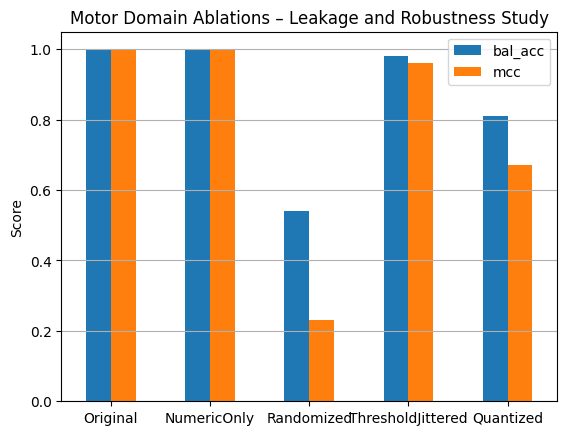

In [ ]:
pose_summary[['bal_acc','mcc']].plot.bar(rot=0)
plt.title("Motor Domain Ablations – Leakage and Robustness Study")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(axis='y')

In [ ]:
def count_outcomes(df):
    """Count correct, incorrect, and deferred cases for an ablation result DataFrame."""
    true_cols = [c for c in df.columns if "true" in c.lower()]
    pred_cols = [c for c in df.columns if any(k in c.lower() for k in ["pred", "decision"])]

    y_true = df[true_cols[0]].astype(str).values
    y_pred = df[pred_cols[0]].astype(str).values

    # --- Counts ---
    total = len(y_true)
    deferred = np.sum(y_pred == "Review")
    correct = np.sum((y_pred == y_true) & (y_pred != "Review"))
    incorrect = np.sum((y_pred != y_true) & (y_pred != "Review"))

    return {
        "Total": total,
        "Correct": correct,
        "Incorrect": incorrect,
        "Deferred": deferred,
        "Coverage": (total - deferred) / total,
        "Accuracy@Covered": correct / (total - deferred) if (total - deferred) > 0 else np.nan,
    }

def summarize_counts(results_dict):
    """Return a compact DataFrame of outcome counts per ablation."""
    return pd.DataFrame({name: count_outcomes(df) for name, df in results_dict.items()}).T

In [ ]:
summary_counts = summarize_counts(pose_results)

print("\n=== Motor PhysioGPT Outcome Counts ===")
display(summary_counts)


=== Motor PhysioGPT Outcome Counts ===


,Total,Correct,Incorrect,Deferred,Coverage,Accuracy@Covered
NumericOnly,100.0,100.0,0.0,0.0,1.00,1.000000
Randomized,100.0,53.0,34.0,13.0,0.87,0.609195
ThresholdJittered,100.0,98.0,2.0,0.0,1.00,0.980000
Quantized,100.0,79.0,20.0,1.0,0.99,0.797980


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_physio_summary(summary_counts: pd.DataFrame, title="PhysioGPT Ablation", save_prefix=None):
    """
    Plot accuracy and outcome distribution from summary_counts DataFrame.

    Expected columns:
      ['Correct', 'Incorrect', 'Deferred', 'Accuracy@Covered']
    """
    # Reset index to access variant names (like 'Original', 'NumericOnly', etc.)
    df = summary_counts.reset_index().rename(columns={"index": "Variant"})

    # --- Plot 1: Accuracy @ Covered ---
    plt.figure(figsize=(7, 4))
    plt.bar(df["Variant"], df["Accuracy@Covered"], color="#2db483", alpha=0.9)
    plt.title(f"{title} – Accuracy @ Covered", fontsize=13, weight="bold")
    plt.ylabel("Accuracy", fontsize=12)
    plt.ylim(0, 1.05)
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.xticks(rotation=30, ha="right", fontsize=11)
    plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_accuracy.png", dpi=300, bbox_inches="tight")
    plt.show()

    # --- Plot 2: Stacked outcome proportions ---
    cols = ["Correct", "Incorrect", "Deferred"]
    totals = df[cols].sum(axis=1)
    proportions = df[cols].div(totals, axis=0)

    plt.figure(figsize=(7, 4))
    bottom = np.zeros(len(df))
    colors = ["#2db483", "#e57373", "#fbc02d"]
    for col, color in zip(cols, colors):
        plt.bar(df["Variant"], proportions[col], bottom=bottom, label=col, color=color, alpha=0.9)
        bottom += proportions[col].fillna(0).values

    plt.title(f"{title} – Outcome Distribution", fontsize=13, weight="bold")
    plt.ylabel("Proportion of Subjects", fontsize=12)
    plt.ylim(0, 1)
    plt.legend(
        frameon=True,
        facecolor="white",
        edgecolor="lightgray",
        loc="lower right",
        fontsize=10
    )

    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.xticks(rotation=30, ha="right", fontsize=11)
    plt.tight_layout()
    if save_prefix:
        plt.savefig(f"{save_prefix}_outcomes.png", dpi=300, bbox_inches="tight")
    plt.show()

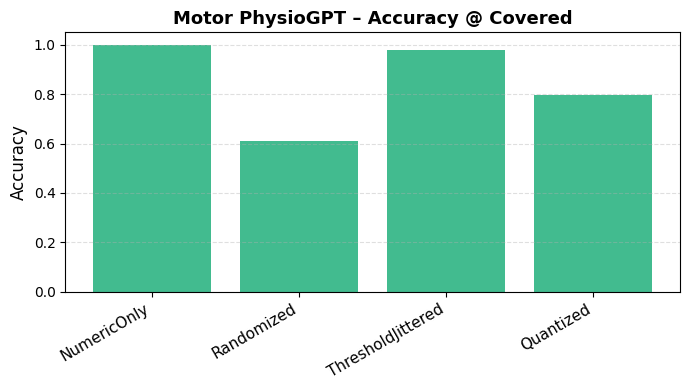

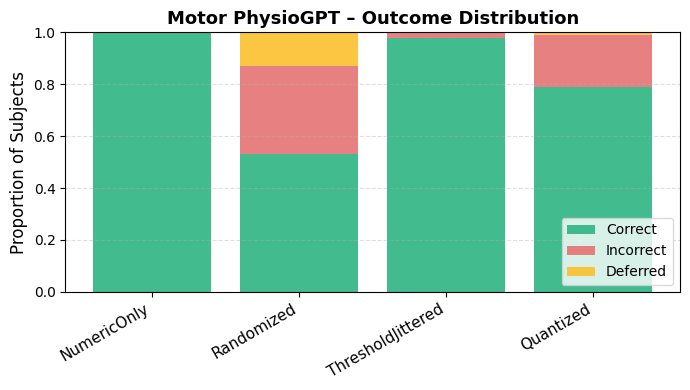

In [ ]:
plot_physio_summary(summary_counts, title="Motor PhysioGPT")

# Baseline (Raw Features)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Extract numeric-only features (same ones in motor_numeric_only_prompt)
feat_cols = ["hip_range", "knee_range", "ankle_range",
             "hip_acc_std", "knee_acc_std", "ankle_acc_std",
             "hip_jerk", "knee_jerk", "ankle_jerk"]

X = []
y = []
for subj in pose_df["Subject"].unique():
    s = generate_full_motor_summary(pose_df, subj)
    X.append([s["Pose Summary"][c] for c in feat_cols])
    y.append(int(pose_df.loc[pose_df["Subject"]==subj,"Label"].iloc[0]))  # 1=Stroke, 0=Control

clf = LogisticRegression(max_iter=1000).fit(X, y)
print(classification_report(y, clf.predict(X)))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



# Baselines (Summaries)

In [20]:
example_output = generate_full_motor_summary(pose_df, pose_df["Subject"].iloc[0])
print(example_output)

{'Pose Summary': {'hip_range': 43.16205492294609, 'knee_range': 60.76937898340793, 'ankle_range': 26.80391323102335, 'hip_acc_std': 0.10577100736225821, 'knee_acc_std': 0.19638187656146733, 'ankle_acc_std': 0.08800938445395629, 'hip_jerk': 0.0010257104639984822, 'knee_jerk': 0.005269796358800677, 'ankle_jerk': 0.0020016828524644925, 'hip_mean': np.float64(11.075423456712485), 'knee_mean': np.float64(24.41124545302006), 'ankle_mean': np.float64(2.633495518440832)}}


In [21]:
# === Evaluate ML baselines on PhysioGPT-level summaries ===
import numpy as np, pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, matthews_corrcoef,
    f1_score, classification_report
)

# 1️⃣ Extract the same per-subject summaries that feed the LLM
summaries = []
for subj_id in pose_df["Subject"].unique():
    s = generate_full_motor_summary(pose_df, subj_id)
    pose_data = s["Pose Summary"]  # we know this key exists

    # Infer label from subject name (contains 'Stroke' or 'Control')
    label = 1 if "Stroke" in subj_id else 0

    summaries.append({
        "Subject": subj_id,
        "Label": label,
        **{k: float(v) for k, v in pose_data.items()}  # ensure all numeric
    })

df_summaries = pd.DataFrame(summaries)
print("✅ Built summaries:", df_summaries.shape)
display(df_summaries.head())

✅ Built summaries: (100, 14)


,Subject,Label,hip_range,knee_range,ankle_range,hip_acc_std,knee_acc_std,ankle_acc_std,hip_jerk,knee_jerk,ankle_jerk,hip_mean,knee_mean,ankle_mean
0,Sub01_Control,0,43.162055,60.769379,26.803913,0.105771,0.196382,0.088009,0.001026,0.005270,0.002002,11.075423,24.411245,2.633496
1,Sub02_Control,0,35.541291,42.963785,20.065645,0.387998,0.138828,0.083309,0.380733,0.038670,0.039809,25.048347,22.657149,2.415438
2,Sub03_Control,0,43.636848,50.713423,26.485989,0.100283,0.156503,0.089328,0.001101,0.024522,0.013864,22.932520,20.196128,3.745019
3,Sub04_Control,0,40.238062,51.963995,20.674839,0.325635,0.177791,0.083749,0.310376,0.064063,0.044906,15.215377,21.883510,1.970772
4,Sub05_Control,0,38.053763,41.340255,16.515583,0.088504,0.130307,0.085965,0.021322,0.025615,0.066680,14.783640,18.935461,3.815107


In [22]:
X = df_summaries.drop(columns=["Subject", "Label"]).values
y = df_summaries["Label"].values

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import pandas as pd
import numpy as np

# --- Split data ---
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# --- Determine positive label automatically ---
def get_pos_label(y):
    # if y contains strings like "Stroke"/"Control"
    if np.array(y).dtype.kind in {"U", "S", "O"}:
        return "Stroke"
    # else assume numeric encoding: 1 = Stroke (positive)
    return 1

pos_label = get_pos_label(y_te)

# --- Define models ---
models = {
    "SVM (RBF)": SVC(kernel="rbf", random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "k-NN (k=5)": KNeighborsClassifier(n_neighbors=5),
    # Optional alternative:
    # "Gradient Boosting": GradientBoostingClassifier(random_state=42),
}

# --- Evaluate models ---
rows = []
for name, clf in models.items():
    pipe = make_pipeline(StandardScaler(), clf)
    pipe.fit(X_tr, y_tr)
    y_pred = pipe.predict(X_te)

    acc  = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, pos_label=pos_label, zero_division=0)
    rec  = recall_score(y_te, y_pred, pos_label=pos_label, zero_division=0)
    f1   = f1_score(y_te, y_pred, pos_label=pos_label, zero_division=0)

    rows.append({
        "Model": name,
        "Accuracy": round(acc, 2),
        "Precision": round(prec, 2),
        "Recall": round(rec, 2),
        "F1": round(f1, 2),
    })

pose_ml = pd.DataFrame(rows)[["Model", "Accuracy", "Precision", "Recall", "F1"]]
print(pose_ml.to_markdown(index=False))

| Model         |   Accuracy |   Precision |   Recall |   F1 |
|:--------------|-----------:|------------:|---------:|-----:|
| SVM (RBF)     |       0.73 |        0.82 |     0.6  | 0.69 |
| Random Forest |       0.77 |        0.83 |     0.67 | 0.74 |
| k-NN (k=5)    |       0.73 |        0.89 |     0.53 | 0.67 |
